In [1]:
import numpy as np
from larch import Group
from glob import glob
import re
import matplotlib.pyplot as plt
from os import path
import os
from zanes.zanes import data_analysis as da
from scipy.interpolate import interp1d
import pandas as pd


# data analysis for non-modulation measurements

In [2]:
!git clone https://github.com/kaifengZheng/zanes.git

fatal: destination path 'zanes' already exists and is not an empty directory.


In [3]:
def data_collect(datadict,tag):
    E_achi,mu_achi,mu_achi_get,E_achi=[],[],[],[]
    E_max,E_min=[],[]
    for file  in datadict[tag]:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
        E_max.append(E_get[-1])
        E_min.append(E_get[0])
    E_mesh=np.linspace(np.max(E_min),np.min(E_max),500)
    for i in range(len(mu_achi)):
        mu_achi_get.append(interp1d(E_achi[i],mu_achi[i])(E_mesh))
    return E_mesh,np.array(mu_achi_get)

def get_ave(E,mu):
    return E,mu.mean(axis=0)
def plot_data(E,mu,tag):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E,mu[i],label=tag,alpha=0.3)
        else:
            plt.plot(E,mu[i],alpha=0.3)
    plt.plot(E,mu.mean(axis=0),label='mean',color='red')
    plt.legend(frameon=False)
    
def get_datadict(filenames):
    name_dict=dict()
    for name in filenames:
        basednames=path.basename(name)
        match_name=re.match('(^.+)\s+',basednames)[0]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[]
        if match_name in name:
            name_dict[match_name].append(name)
    return name_dict
def read_data(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],data[:,4]/data[:,1] #flou data

def get_larch_groups(datadict,tag):
    E_achi,mu_achi=data_collect(datadict,tag)
    
    groups=[]
    for i in range(len(mu_achi)):
        groups.append(Group(energy=E_achi,mu=mu_achi[i],label=path.basename(datadict[tag][i])))
    return groups
              

In [4]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/1/313272/*.dat"), key=os.path.getmtime,reverse=True)

In [5]:
name_dict=get_datadict(filenames)

In [6]:
keys=list(name_dict.keys())
print("show key_num and corresponding measurement")
for i in range(len(keys)):
    print(f"{i}\t{keys[i]}")

show key_num and corresponding measurement
0	Pd foil sample position k20 
1	Pd foil reference position k20 
2	Pd foil reference position 
3	ME20PostMES_at_400C_in_H2_S1_Pd20Au80_ Pd_  
4	ME20PostMES_at_400C_in_O2_S1_Pd20Au80_ Pd_  
5	ME20_MES_at_400C_30sH230sO230sCH4_S1_Pd20Au80_ Pd_28osc_  
6	ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_  
7	ME18_MES_at_400C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_  
8	ME17_MES_at_250C_30sH2_30sO2_30sCH4_S1_Pd20Au80_ Pd_28osc_  
9	test_ME17 
10	ME16_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_  
11	ME15_MES_at_250C_60ssH2_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_  
12	ME14_MES_at_250C_30sCH4_30sO2_S1_Pd20Au80_ Pd_60s60s_18osc_  
13	ME13_MES_at_250C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_  
14	ME12_MES_at_250C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_  
15	ME11PostMES_at_250C_in_CH4_S1_Pd20Au80_ Pd_  
16	ME11_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80__after_O260s_H260s_ Pd_60s60s_18osc_  
17	ME10PreMES_at_250C_in_H2_S1_Pd20Au80_ Pd_60s60s_18osc_  
18	DH09PreM

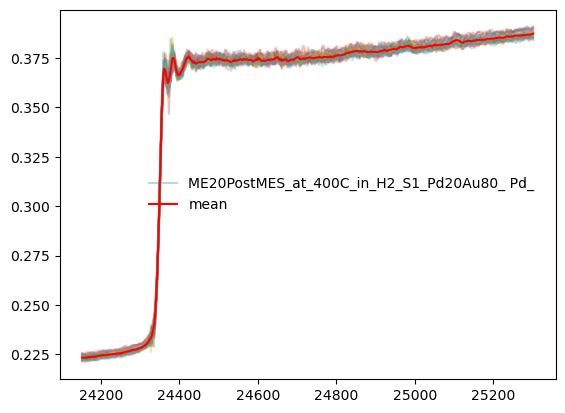

In [7]:
key_num=3
E,mu=data_collect(name_dict,keys[key_num])
plot_data(E,mu,keys[key_num])
E_ave,mu_ave=get_ave(E,mu)

In [8]:
groups=get_larch_groups(name_dict,tag=keys[key_num])
group_ave=Group(energy=E_ave,mu=mu_ave,label=keys[key_num])

In [9]:
for i in range(len(groups)):
    da.data_processing(groups[i],e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,8])


E0=24350.17348929459


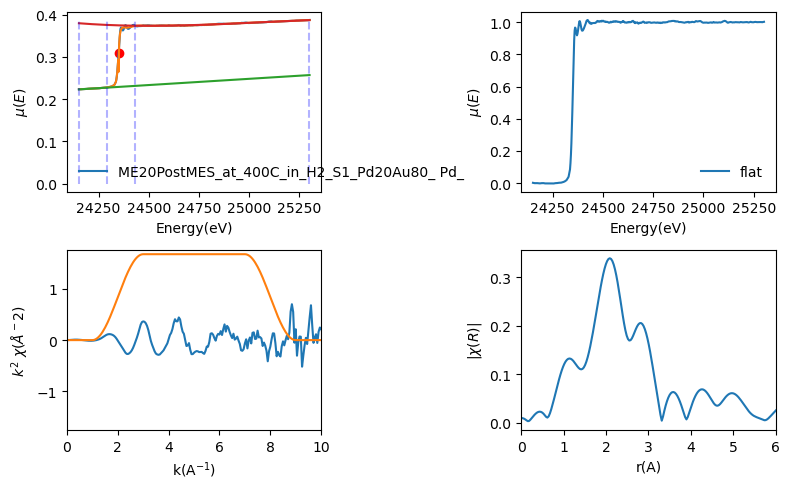

In [10]:
da.data_processing(group_ave,e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,8])

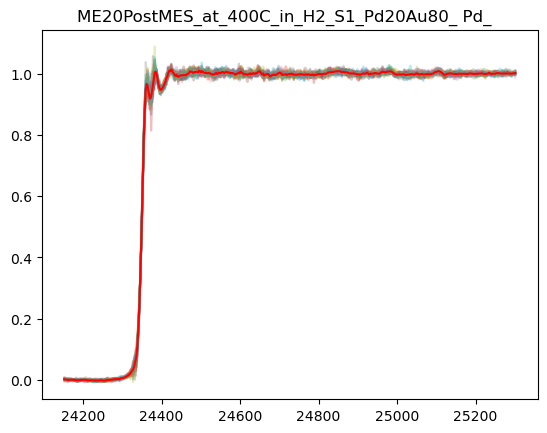

In [11]:
plt.figure()
for i in range(len(groups)):
    plt.plot(groups[i].energy,groups[i].flat,alpha=0.3)
plt.title(keys[key_num])
plt.plot(group_ave.energy,group_ave.flat,color='red')

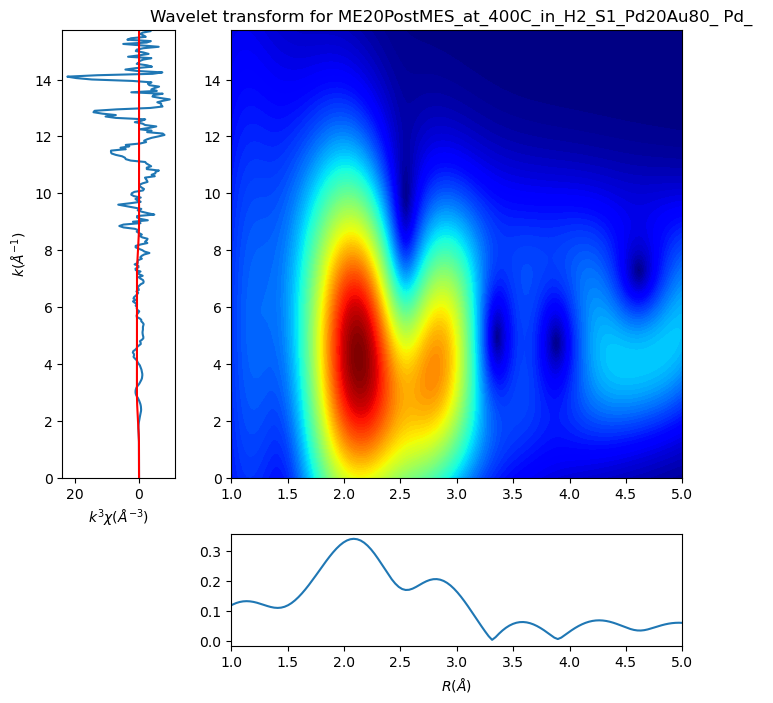

In [12]:
da.wavelet_transform(group_ave, kweight=2, plot=True) #wavelet transform

# data analysis for modulation measurements

In [13]:
def data_dict_modu(filenames):
    name_dict=dict()
    for name in filenames:
        basednames=path.basename(name)
        # print(basednames)
        match_name=re.match('(^.+)\s+(\d+)_(\d+)_([a-z]+)',basednames)[1]
        traj_num=int(re.match('(^.+)\s+(\d+)_(\d+)_([a-z]+)',basednames)[2])
        # print(f"{name} {cycle_num}")
        scan_num=int(re.match('(^.+)\s+(\d+)_(\d+)_([a-z]+)',basednames)[3])
        up_down=re.match('(^.+)\s+(\d+)_(\d+)_([a-z]+)',basednames)[4]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[{'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down}]
        else:
            name_dict[match_name].append({'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down})
    return name_dict
def data_collect(filelist):
    E_achi,mu_achi=[],[]
    for file  in filelist:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
    return np.array(E_achi),np.array(mu_achi)
def name_collect(dict_modu,tag,mode='H2',traj_num=2,total_scan=36): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    
    for data in datapoints:
        if mode=='H2' or mode=='CH4':
            if data['scan_num']>total_scan//2 and data['traj_num']==traj_num:
                names.append(data['full_path'])
        if mode=='O2':
            if data['scan_num']<=total_scan//2 and data['traj_num']==traj_num:
                names.append(data['full_path'])
    return names
def name_collect3(dict_modu,tag,mode='H2',traj_num=2,total_scan=36): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    
    for data in datapoints:
        if mode=='H2':
            if data['scan_num']>=2*total_scan//3 and data['traj_num']==traj_num:
                names.append(data['full_path'])
        if mode=='CH4':
            if (data['scan_num']<2*total_scan//3 and data['scan_num']>=total_scan//3) and data['traj_num']==traj_num:
                names.append(data['full_path'])
        if mode=='O2':
            if data['scan_num']<total_scan//3 and data['traj_num']==traj_num:
                names.append(data['full_path'])
    return names
def plot_data(E,mu,tag,color='r',alpha=0.3):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E[i],mu[i],label=tag,alpha=alpha)
        else:
            plt.plot(E[i],mu[i],alpha=alpha)
    plt.plot(E.mean(axis=0),mu.mean(axis=0),label='mean',color=color)
    plt.legend(frameon=False)
def get_larch_groups(filenames):
    E_achi,mu_achi=data_collect(filenames)
    groups=[]
    for i in range(len(E)):
        groups.append(Group(energy=E_achi[i],mu=mu_achi[i],label=path.basename(filenames[i])))
    return groups
def get_ave(E,mu):
    return E.mean(axis=0),mu.mean(axis=0)
def get_ave_cycle(data_dict,key_num,mode='O2',traj_num=2,total_scan=36):
    """
    data_dict: return value of function data_dict_modu(filenames): details of file information
    key_num: The specific measurement index. 
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in data_dict[key[key_num]]:
        if k['traj_num'] not in traj:
            traj.append(k['traj_num'])
    print(f"num of trajactories:{traj}")
    for t in traj:
        data=name_collect(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan)
        e1,mu1=data_collect(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e_all=np.array(e_all).mean(axis=0)
    mu_all=np.array(mu_all).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all

def get_ave_cycle3(data_dict,key_num,mode='O2',traj_num=2,total_scan=10):
    """
       This script works for the modulation between O, H2 and CH4
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in dic[key[key_num]]:
        if k['traj_num'] not in traj:
            cycles.append(k['traj_num'])
    print(f"traj:{traj}")
    for t in traj:
        data=name_collect3(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan)
        e1,mu1=data_collect(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e_all=np.array(e_all).mean(axis=0)
    mu_all=np.array(mu_all).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all
    
    

In [14]:
%matplotlib widget

In [15]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/1/313272/Oscillatory_processed/*.dat"), key=os.path.getmtime,reverse=True)
data_dict=data_dict_modu(filenames)
key=list(data_dict.keys())
print("show key_num and corresponding measurement:")
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

show key_num and corresponding measurement:
0	ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
1	ME18_MES_at_400C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
2	ME17_MES_at_250C_30sH2_30sO2_30sCH4_S1_Pd20Au80_ Pd_28osc_ 
3	ME16_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
4	ME15_MES_at_250C_60ssH2_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
5	ME14_MES_at_250C_30sCH4_30sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
6	ME13_MES_at_250C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
7	ME12_MES_at_250C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
8	ME11_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80__after_O260s_H260s_ Pd_60s60s_18osc_ 
9	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_36osci_ 
10	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_35osci_ 
11	ME04MES1_H2_S2_Pd8Au92_ fromH2_60sO2_60sH2_ Pd_18osci_ 
12	ME04DuringheatingMES1_400_H2_S2_Pd8Au92_ Pd_Al foil_ 
13	ME01_S1_Pd20Au80_fromH2_60sO2_60sH2_30cycles_
14	ME03MES1_S1_Pd20Au80_fromH2_15sO2_15H2_ Pd_37osci_ 
15	ME01PostMES1_H2_S1_Pd20Au80_
16	S1_Pd_20
17	S1_Pd_20_test
18	

In [16]:
key_num=0
traj_num=1
total_scan=74
table=pd.DataFrame(data_dict[key[key_num]])
table[table['traj_num']==traj_num]
# table: row number is the total scan

,full_path,tag,traj_num,scan_num,up_down
663,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,73,up
664,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,74,dn
668,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,67,up
669,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,69,up
670,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,70,dn
...,...,...,...,...,...
735,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,7,up
736,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,5,up
737,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,6,dn
738,/nsls2/data/qas-new/legacy/processed/2024/1/31...,ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_...,1,2,dn


In [17]:
E_O,mu_O=get_ave_cycle(data_dict,key_num,mode='O2',traj_num=traj_num,total_scan=total_scan)
E_H,mu_H=get_ave_cycle(data_dict,key_num,mode='CH4',traj_num=traj_num,total_scan=total_scan)
# E_CH4,mu_CH4=get_ave_cycle3(dic,key_num,mode='CH4',cycle_num=cycle_num,total_scan=total_scan)


num of trajactories:[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
num of trajactories:[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [18]:
group_ave1=Group(energy=E_O,mu=mu_O,label=f"O2_traj_{traj_num}")
group_ave2=Group(energy=E_H,mu=mu_H,label=f'CH4_traj_{traj_num}')
# group_ave3=Group(energy=E_CH4,mu=mu_CH4,label=f'CH4_cyc_{cycle_num}')

E0=24352.000000000015


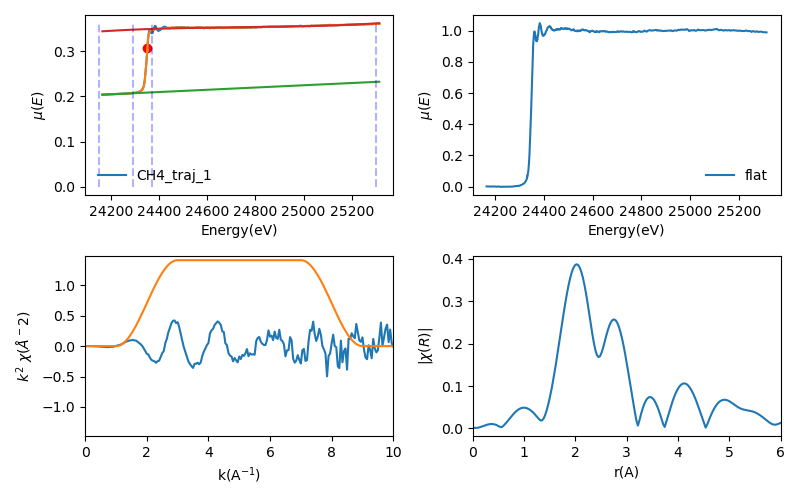

In [19]:
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,8])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,8])
# da.data_processing(group_ave3,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
#                   plot=True,kwin='hanning',dk=2,krange=[2,8])

Text(0.5, 1.0, 'ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ ')

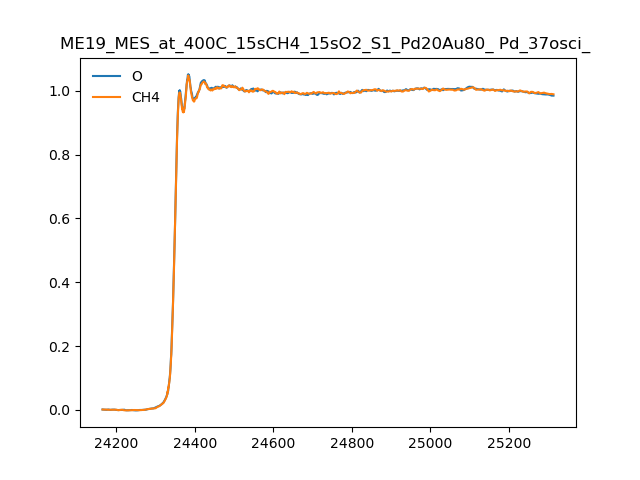

In [20]:
plt.figure()
plt.plot(group_ave1.energy,group_ave1.flat,label='O')
plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])

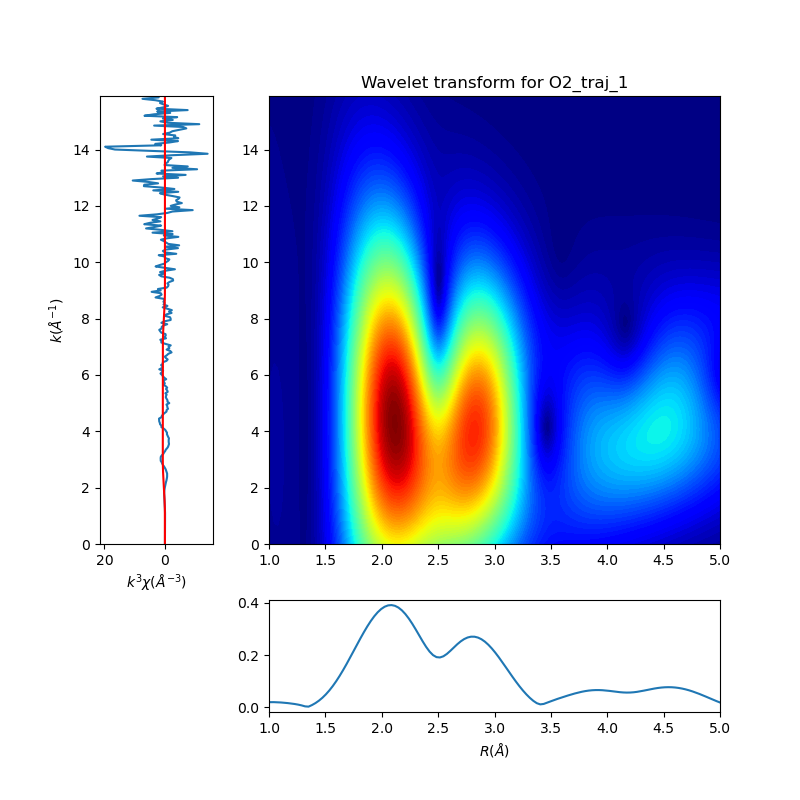

In [21]:
da.wavelet_transform(group_ave1, kweight=2, plot=True)

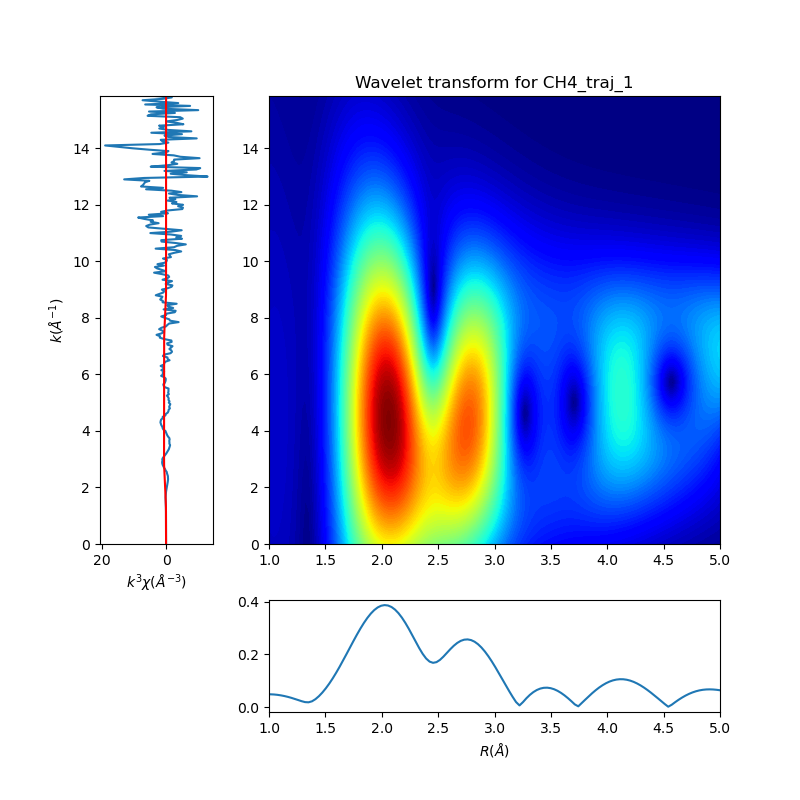

In [22]:
da.wavelet_transform(group_ave2, kweight=2, plot=True)

In [23]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/1/313272/Oscillatory_processed/*.dat"), key=os.path.getmtime,reverse=True)
dic=data_dict_modu(filenames)
key=list(dic.keys())
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

0	ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
1	ME18_MES_at_400C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
2	ME17_MES_at_250C_30sH2_30sO2_30sCH4_S1_Pd20Au80_ Pd_28osc_ 
3	ME16_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
4	ME15_MES_at_250C_60ssH2_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
5	ME14_MES_at_250C_30sCH4_30sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
6	ME13_MES_at_250C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
7	ME12_MES_at_250C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
8	ME11_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80__after_O260s_H260s_ Pd_60s60s_18osc_ 
9	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_36osci_ 
10	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_35osci_ 
11	ME04MES1_H2_S2_Pd8Au92_ fromH2_60sO2_60sH2_ Pd_18osci_ 
12	ME04DuringheatingMES1_400_H2_S2_Pd8Au92_ Pd_Al foil_ 
13	ME01_S1_Pd20Au80_fromH2_60sO2_60sH2_30cycles_
14	ME03MES1_S1_Pd20Au80_fromH2_15sO2_15H2_ Pd_37osci_ 
15	ME01PostMES1_H2_S1_Pd20Au80_
16	S1_Pd_20
17	S1_Pd_20_test
18	test_pd_osci
